**월간 데이콘 예술 작품 화가 분류 AI 경진대회**

https://dacon.io/competitions/official/236006/overview/description

**[모델]**
*   efficientNet B3
*   스케줄러 적용

**[전처리]**
*   이미지 크기 resize 300
*   1/4 크기로 crop
*   weighted random sampling
*   dropout 추가

## Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import cv2
from PIL import Image

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

## Hyperparameter Setting

In [ ]:
CFG = {
    'IMG_SIZE':300,
    'EPOCHS':10,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
## Fixed RandomSeed

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/KUBIG/24_Spring_DL/contest/open.zip') # 압축을 해제할 '/파일경로/파일명.zip'
zip_file.extractall('/content/') # 압축을 해제할 '/위치경로/'

In [ ]:
#train 폴더 이미지 개수 확인
import glob
train_path = '/content/train'
train_files = glob.glob(train_path + '/*.jpg')
print(len(train_files))

5911


In [ ]:
#test 폴더 이미지 개수 확인
test_path = '/content/test'
test_files = glob.glob(test_path + '/*.jpg')
print(len(test_files))

12670


In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
#   잘못된 라벨 처리하기
# id 3896과 3986이 모두 3896이라는 값을 가지고 있음
print(train_df['id'][3896])
print(train_df['id'][3986])

# 3986의 id를 3896으로 바꿔줌
train_df['id'][3986] = 3986

3896
3896


In [ ]:
print("변경 전:", train_df['artist'][3896])    # Titian으로 수정
train_df['artist'][3896] = 'Titian'
print("변경 후:", train_df['artist'][3896])    # 변경 후 확인

변경 전: Edgar Degas
변경 후: Titian


In [ ]:
print("변경 전:", train_df['artist'][3986])   # Algred Sislye로 수정
train_df['artist'][3986] = 'Alfred Sisley'
print("변경 후:", train_df['artist'][3986])

변경 전: Titian
변경 후: Alfred Sisley


## EDA

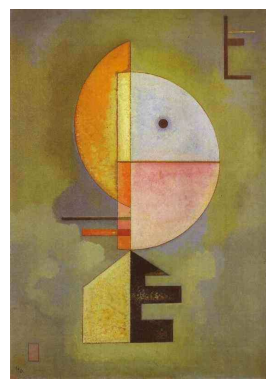

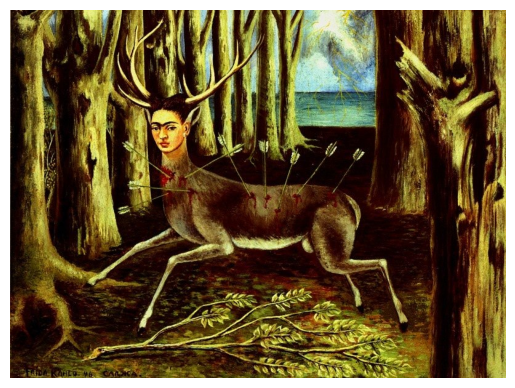

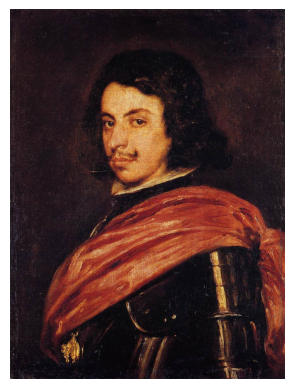

In [ ]:
# train 폴더에 들어있는 이미지 확인

# 랜덤으로 인덱스 3개 선택
random_indices_train = random.sample(range(len(train_files)), 3)

# 선택된 랜덤한 인덱스에 해당하는 이미지를 표시
for idx in random_indices_train:

    # 이미지 파일 경로
    image_path = train_files[idx]

    # 이미지 열기
    img = Image.open(image_path)

    # 이미지 표시
    plt.imshow(img)
    plt.axis('off')  # 축 제거
    plt.show()

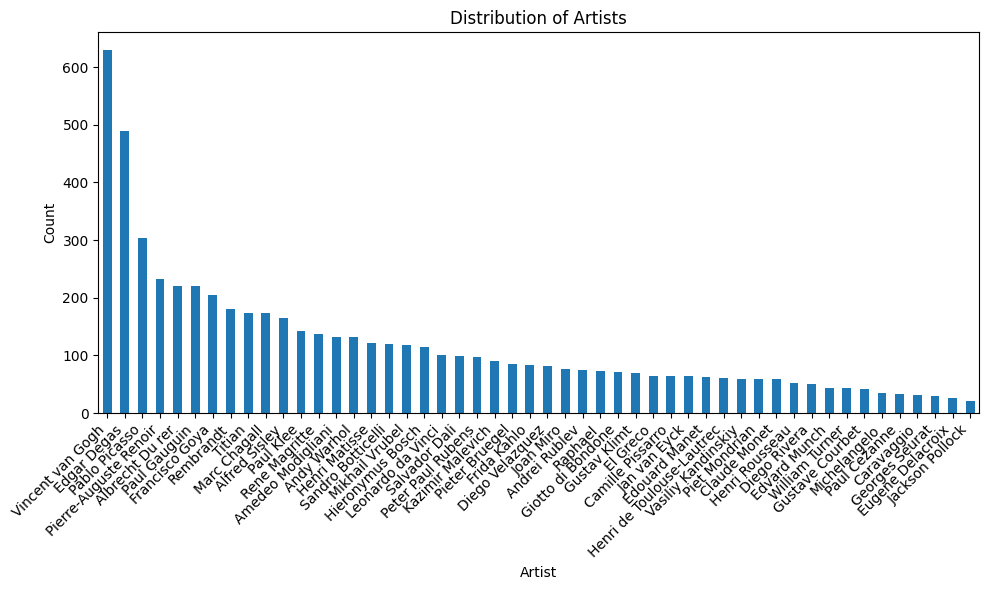

In [ ]:
# class imbalance 확인

import matplotlib.pyplot as  plt

artist_counts = train_df['artist'].value_counts()

# 그래프 그리기
plt.figure(figsize=(10, 6))
artist_counts.plot(kind='bar')
plt.title('Distribution of Artists')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # X 축 레이블을 45도 기울임
plt.tight_layout()
plt.show()

In [ ]:
print(artist_counts)

Vincent van Gogh             629
Edgar Degas                  489
Pablo Picasso                303
Pierre-Auguste Renoir        233
Albrecht Du rer              220
Paul Gauguin                 220
Francisco Goya               204
Rembrandt                    181
Titian                       173
Marc Chagall                 173
Alfred Sisley                165
Paul Klee                    142
Rene Magritte                137
Amedeo Modigliani            132
Andy Warhol                  132
Henri Matisse                121
Sandro Botticelli            120
Mikhail Vrubel               118
Hieronymus Bosch             115
Leonardo da Vinci            101
Salvador Dali                 99
Peter Paul Rubens             97
Kazimir Malevich              91
Pieter Bruegel                85
Frida Kahlo                   84
Diego Velazquez               81
Joan Miro                     76
Andrei Rublev                 74
Raphael                       73
Giotto di Bondone             72
Gustav Kli

In [ ]:
# 각 이미지별로, 이미지의 크기가 다름을 확인할 수 있음
# 예시로 앞에서부터 10개 이미지 뽑아서 크기 출력
for idx in range(10):
  image = Image.open(train_files[idx])
  image_size = image.size     #원본 이미지 사이즈 확인

  print("Train Image size (width, height):", image_size)

Train Image size (width, height): (1539, 2048)
Train Image size (width, height): (596, 807)
Train Image size (width, height): (996, 448)
Train Image size (width, height): (733, 1073)
Train Image size (width, height): (2024, 2632)
Train Image size (width, height): (1872, 2553)
Train Image size (width, height): (1241, 1024)
Train Image size (width, height): (564, 739)
Train Image size (width, height): (888, 1131)
Train Image size (width, height): (565, 750)


In [ ]:
# test 이미지에 대해서도 확인.
# train 이미지에 비해 작은 크기 (가로 1/2, 세로 1/2 정도) 가 된 것을 확인할 수 있음
# test 데이터에서는 그림의 일부분만 주어진 것이 경진대회의 핵심 키!

# 예시로 앞에서부터 10개 이미지 뽑아서 크기 출력
for idx in range(10):
  image = Image.open(test_files[idx])
  image_size = image.size     #원본 이미지 사이즈 확인

  print("Train Image size (width, height):", image_size)

Train Image size (width, height): (328, 388)
Train Image size (width, height): (640, 382)
Train Image size (width, height): (375, 500)
Train Image size (width, height): (334, 492)
Train Image size (width, height): (996, 828)
Train Image size (width, height): (400, 314)
Train Image size (width, height): (438, 512)
Train Image size (width, height): (433, 512)
Train Image size (width, height): (500, 343)
Train Image size (width, height): (424, 512)


In [ ]:
#흑백 이미지가 존재함을 확인
#흑백 이미지만 뽑아서 확인
data_directory = "./train/"

# Iterate through all files in the directory
for filename in os.listdir(data_directory):
    # Join the directory path with the filename to get the full file path
    filepath = os.path.join(data_directory, filename)

    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more extensions if needed
        # Open the image
        image = Image.open(filepath)

        # Check if the image is black and white (grayscale)
        if image.mode == "L":
            print("Black and white image found:", filename)
            # You can perform further processing here, like copying or moving the image to another directory

Black and white image found: 4127.jpg
Black and white image found: 2727.jpg
Black and white image found: 5312.jpg
Black and white image found: 5613.jpg
Black and white image found: 0282.jpg
Black and white image found: 5838.jpg
Black and white image found: 4699.jpg
Black and white image found: 4599.jpg
Black and white image found: 4473.jpg
Black and white image found: 4111.jpg
Black and white image found: 4158.jpg
Black and white image found: 0544.jpg
Black and white image found: 5033.jpg
Black and white image found: 4092.jpg
Black and white image found: 2532.jpg
Black and white image found: 5349.jpg
Black and white image found: 5152.jpg
Black and white image found: 5517.jpg
Black and white image found: 3193.jpg
Black and white image found: 2817.jpg
Black and white image found: 4172.jpg
Black and white image found: 3994.jpg
Black and white image found: 1584.jpg
Black and white image found: 0555.jpg
Black and white image found: 1705.jpg
Black and white image found: 0789.jpg
Black and wh

In [ ]:
#흑백 작품을 주로 그리는 화가가 있을 것이란 가정 하에, 해당 작품들의 artist를 출력
black_white_filenames = [
    "5625.jpg", "4172.jpg", "3710.jpg", "3002.jpg", "0555.jpg", "3602.jpg", "4164.jpg",
    "1705.jpg", "4111.jpg", "5838.jpg", "4092.jpg", "0969.jpg", "2532.jpg", "5292.jpg",
    "4473.jpg", "2817.jpg", "5613.jpg", "0789.jpg", "4699.jpg", "1167.jpg", "0282.jpg",
    "5033.jpg", "0786.jpg", "4599.jpg", "4127.jpg", "5823.jpg", "3994.jpg", "4158.jpg",
    "3193.jpg", "0544.jpg", "5152.jpg", "5349.jpg", "5312.jpg", "4854.jpg", "0742.jpg",
    "5615.jpg", "5423.jpg", "4516.jpg", "5092.jpg", "3560.jpg", "1584.jpg", "5517.jpg",
    "2727.jpg"
]

black_white_df = train_df[train_df['img_path'].str.split('/').str[-1].isin(black_white_filenames)]

print(black_white_df[['img_path', 'artist']])

              img_path             artist
282   ./train/0282.jpg     Francisco Goya
544   ./train/0544.jpg     Francisco Goya
555   ./train/0555.jpg     Francisco Goya
742   ./train/0742.jpg     Francisco Goya
786   ./train/0786.jpg     Francisco Goya
789   ./train/0789.jpg     Francisco Goya
969   ./train/0969.jpg     Francisco Goya
1167  ./train/1167.jpg     Francisco Goya
1584  ./train/1584.jpg     Francisco Goya
1705  ./train/1705.jpg     Francisco Goya
2532  ./train/2532.jpg     Francisco Goya
2727  ./train/2727.jpg      Pablo Picasso
2817  ./train/2817.jpg     Francisco Goya
3002  ./train/3002.jpg     Francisco Goya
3193  ./train/3193.jpg     Francisco Goya
3560  ./train/3560.jpg     Francisco Goya
3602  ./train/3602.jpg     Francisco Goya
3710  ./train/3710.jpg     Francisco Goya
3994  ./train/3994.jpg     Francisco Goya
4092  ./train/4092.jpg     Francisco Goya
4111  ./train/4111.jpg     Francisco Goya
4127  ./train/4127.jpg     Francisco Goya
4158  ./train/4158.jpg     Francis

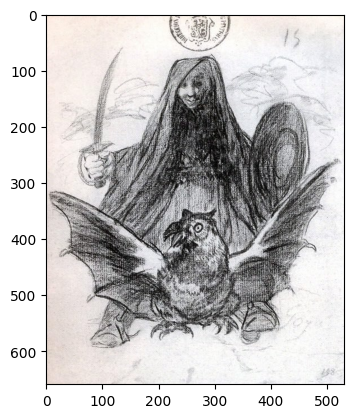

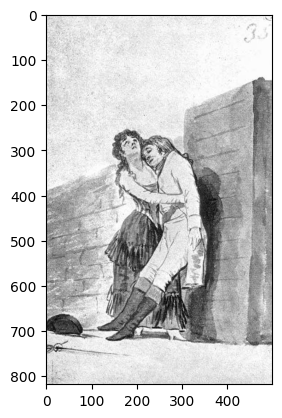

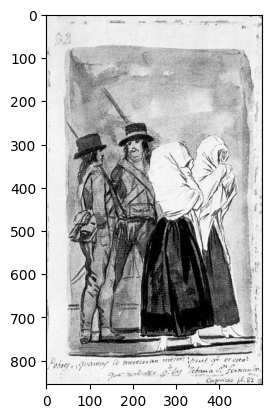

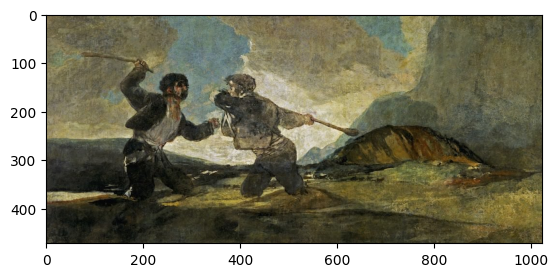

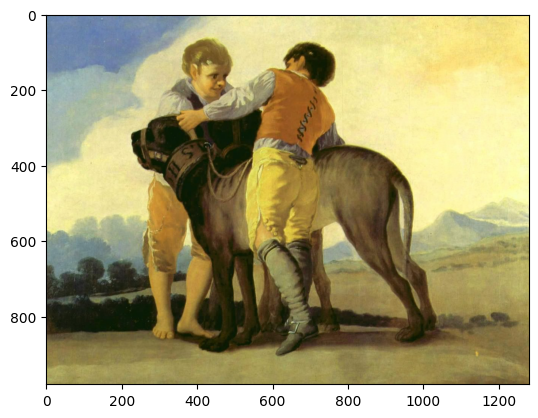

In [ ]:
#Francisco Goya의 지분이 가장 많음을 확인함
#Francisco Goya는 204장의 그림을 그렸으므로 모든 그림이 흑백인 것은 아니며, 다른 화가도 일부 흑백그림을 몇장 그렸음

artist_grey = train_df[train_df['artist'] == 'Francisco Goya']

for index, row in artist_grey.head(5).iterrows():   #Francisco Goya의 작품을 대표로 5장만 출력
    image_path = row['img_path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()

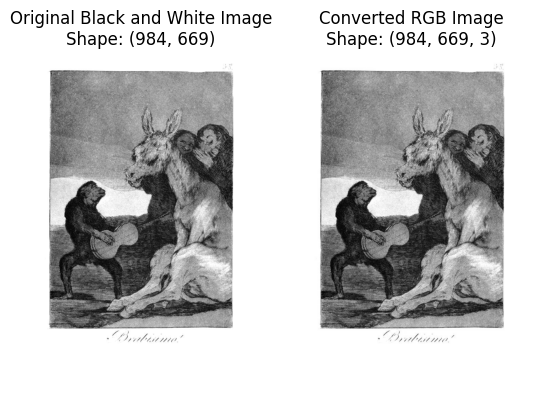

In [ ]:
#모델에는 같은 차원의 이미지를 넣어주어야 하므로 흑백 이미지도 모두 RGB로 바꾸어주고자 함
#흑백 이미지를 RGB로 convert 했을 때 시각적 차이가 있는지 확인해보기
bw_img_path = "./train/3994.jpg"
bw_img = Image.open(bw_img_path)

rgb_img = bw_img.convert("RGB")

# Get the shapes of the images
bw_shape = np.array(bw_img).shape
rgb_shape = np.array(rgb_img).shape

# Plot the original black and white image
plt.subplot(1, 2, 1)
plt.imshow(bw_img, cmap="gray")
plt.title(f"Original Black and White Image\nShape: {bw_shape}")
plt.axis('off')

# Plot the converted RGB image
plt.subplot(1, 2, 2)
plt.imshow(rgb_img)
plt.title(f"Converted RGB Image\nShape: {rgb_shape}")
plt.axis('off')

plt.show()
#그냥 차원만 바뀌고 시각적 차이는 없는 듯함

## Train / Validation Split

In [ ]:
# 화가 이름 Label Encoding
le = preprocessing.LabelEncoder()
train_df['artist'] = le.fit_transform(train_df['artist'].values)

In [ ]:
# df 데이터 프레임과 대응하는 레이블을 이용하여 데이터 분할
train_df, val_df, _, _ = train_test_split(train_df, train_df['artist'].values, test_size=0.2, random_state=CFG['SEED'])

In [ ]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
2,2,./train/0002.jpg,7
3,3,./train/0003.jpg,10
5,5,./train/0005.jpg,38
6,6,./train/0006.jpg,43


In [ ]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
1,1,./train/0001.jpg,48
4,4,./train/0004.jpg,24
17,17,./train/0017.jpg,10
21,21,./train/0021.jpg,29
29,29,./train/0029.jpg,28


## Data Load

In [ ]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['artist'].values

In [ ]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_filename = str(self.dataframe.iloc[idx, 0]).zfill(4) + '.jpg'
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert('RGB')   #흑백 이미지도 모두 RGB로 convert

        if self.transform:
            image_np = np.array(image)  # Convert PIL image to numpy array
            augmented = self.transform(image=image_np)
            image = augmented['image']  # The transformed image is now a torch tensor if ToTensorV2() is used

        # Use the pre-encoded labels directly
        label = self.dataframe.iloc[idx]['artist']
        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [ ]:
train_transforms = A.Compose([
                            A.RandomResizedCrop(CFG['IMG_SIZE'], CFG['IMG_SIZE'], scale=(0.25, 0.25)),  #입력 데이터의 1/4 크기로 crop된 이미지 데이터를 생성
                              #A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
                              #A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.ShiftScaleRotate(p=0.5),    #아래 설명 참고
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

val_transforms = A.Compose([
                           A.RandomResizedCrop(CFG['IMG_SIZE'], CFG['IMG_SIZE'], scale=(0.25, 0.25)),  #입력 데이터의 1/4 크기로 crop된 이미지 데이터를 생성
                              #A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
                              #A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

*   Rotate:
  *   이미지를 지정된 각도만큼 회전시킴
  *   이미지 전체를 중심 또는 지정된 피벗 포인트를 중심으로 회전시킴

*   ShiftScaleRotate:
  *   이동, 크기 조절 및 회전을 결합한 변환
  *   회전뿐만 아니라 이미지의 무작위 이동 및 크기 조절을 포함
*   회전 각도 범위뿐만 아니라 이동 및 크기 조절 요인의 범위를 제어할 수 있어 단순한 회전만을 원한다면 'Rotate'를 사용하고, 보다 다양한 변환을 원한다면 'ShiftScaleRotate'를 사용함.

### Weighted Random Sampling

train 데이터에 존재하는 작가의 작품 개수가 불균등하므로 모든 작가의 작품을 균등하게 학습할 수 있도록 Weighted Random Sampling 진행

[코드 참고 링크](https://yeong-jin-data-blog.tistory.com/entry/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EC%8A%A4%ED%84%B0%EB%94%94-%ED%81%B4%EB%9E%98%EC%8A%A4-%EB%B6%88%EA%B7%A0%ED%98%95-%EB%8B%A4%EB%A3%A8%EA%B8%B0-%EA%B0%80%EC%A4%91-%EB%AC%B4%EC%9E%91%EC%9C%84-%EC%83%98%ED%94%8C%EB%A7%81-%EA%B0%80%EC%A4%91-%EC%86%90%EC%8B%A4-%ED%95%A8%EC%88%98)

In [ ]:
def make_weights(labels, nclasses): # 클래스 불균형을 다루기 위해 가중치 생성
    labels = np.array(labels)
    weight_arr = np.zeros_like(labels)

    _, counts = np.unique(labels, return_counts=True) #레이블에서 고유한 클래스 찾고 클래스별로 이미지 개수 카운트
    for cls in range(nclasses):
        weight_arr = np.where(labels == cls, 1/counts[cls], weight_arr)
        # 각 클래스의의 인덱스를 산출하여 해당 클래스 개수의 역수를 확률로 할당한다.
        # 이를 통해 각 클래스의 전체 가중치를 동일하게 한다.

    return weight_arr

weights = make_weights(train_labels, len(np.unique(train_labels)))
weights = torch.DoubleTensor(weights)

In [ ]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [ ]:
train_dataset = CustomDataset(dataframe=train_df, img_dir=train_path, transform=train_transforms)
val_dataset = CustomDataset(dataframe=val_df, img_dir=train_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, pin_memory=True, sampler = sampler)    #sampler(weights)와 shuffle을 같이 쓸 수 없어 shuffle 삭제
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)

In [ ]:
#이미지 데이터 잘 받아오는지 확인
X, y = train_dataset.__getitem__(0)

train_dataset.__getitem__(0)

(tensor([[[-0.3712, -0.2171, -0.2856,  ..., -1.1247, -1.1418, -0.8335],
          [-0.2171, -0.1657, -0.1486,  ..., -1.2445, -1.4500, -1.0733],
          [-0.1828, -0.3369, -0.4054,  ..., -1.2617, -1.1418, -1.0048],
          ...,
          [-1.5185, -1.5185, -1.5357,  ..., -1.5699, -1.4843, -1.5870],
          [-1.5014, -1.5014, -1.5014,  ..., -1.5185, -1.5014, -1.6213],
          [-1.4843, -1.4329, -1.5185,  ..., -1.5699, -1.5699, -1.5357]],
 
         [[-0.7227, -0.5651, -0.6352,  ..., -1.3004, -1.3004, -1.0028],
          [-0.5651, -0.5126, -0.4951,  ..., -1.4230, -1.6331, -1.2479],
          [-0.5301, -0.6877, -0.7577,  ..., -1.4405, -1.3179, -1.1779],
          ...,
          [-1.6681, -1.6681, -1.7031,  ..., -1.6681, -1.5805, -1.6856],
          [-1.6506, -1.6506, -1.6506,  ..., -1.6155, -1.5980, -1.7206],
          [-1.6331, -1.5805, -1.6681,  ..., -1.6681, -1.6506, -1.6331]],
 
         [[-0.8458, -0.6715, -0.7064,  ..., -1.0550, -1.0724, -0.7587],
          [-0.6890, -0.6193,

## Model Define

In [ ]:
#del model

In [ ]:
#torch.cuda.empty_cache()

### EfficientNet_B3

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5ecabd62fff4ad1a557a515f59ac60ff3e09a6c1a18348566b01c7d91ea02d2c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [ ]:
# class efficientnet_b3(nn.Module):
#     def __init__(self, num_classes=len(le.classes_), fine_tune=True):
#         super(efficientnet_b3, self).__init__()
#         self.backbone = EfficientNet.from_pretrained('efficientnet-b3')

#         if fine_tune:
#             for param in self.backbone.parameters():
#                 param.requires_grad = True
#         else:
#             for param in self.backbone.parameters():
#                 param.requires_grad = False

#         self.classifier = nn.Linear(1000, num_classes)

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.classifier(x)
#         return x

In [ ]:
class efficientnet_b3(nn.Module):
    def __init__(self, num_classes=len(le.classes_), fine_tune=True, dropout_rate=0.2):
        super(efficientnet_b3, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')

        # Set whether to fine-tune or freeze the backbone
        for param in self.backbone.parameters():
            param.requires_grad = fine_tune

        # Add dropout layer   모델이 커져서 과적합 발생하므로 dropout 추가
        self.dropout = nn.Dropout(p=dropout_rate)

        # Classifier layer
        self.classifier = nn.Linear(1000, num_classes)

    def forward(self, x):
        # Backbone
        x = self.backbone(x)

        # Dropout
        x = self.dropout(x)

        # Classifier
        x = self.classifier(x)

        return x

In [ ]:
num_classes = 50

#model = CustomEfficientNet(num_classes=num_classes)
model = efficientnet_b3(num_classes=num_classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 168MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
# # class 불균형 문제 해결 -> 가중손실함수

# import torch.optim as optim
# import torch.nn as nn
# import torch

# # 'artist' 열에 대한 클래스 가중치 계산
# class_sample_count = train_df['artist'].value_counts().sort_index().values
# weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
# weights = weights / weights.sum()  # 가중치 정규화

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# weights = weights.to(device)

In [ ]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습을 위한 장치 설정 (GPU 사용 가능한 경우)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

efficientnet_b3(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [ ]:
num_classes = len(np.unique(train_df['artist']))

class CustomModel(nn.Module):
    # 모델 정의, 최종 레이어의 출력 크기가 num_classes와 일치하도록 합니다.
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        # 최종 레이어까지의 모델 구조
        self.classifier = nn.Linear(in_features, num_classes)  # in_features를 적절히 조정

max_label = train_df['artist'].max()
print("최대 레이블 인덱스:", max_label)
print("모델이 예상하는 클래스 수:", num_classes)

최대 레이블 인덱스: 49
모델이 예상하는 클래스 수: 50


## Train

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

CUDA_LAUNCH_BLOCKING이 "1"로 설정되면 GPU 작업이 동기화됩니다. 즉, 프로그램은 각 GPU 작업이 완료될 때까지 기다립니다. 이는 디버깅 및 프로파일링에 유용하며 오류가 발생할 경우 더 정확한 스택 추적을 제공하고 GPU 작업의 타이밍을 더 잘 이해할 수 있게 합니다.

그러나 CUDA_LAUNCH_BLOCKING을 "1"로 설정하면 프로그램의 실행이 상당히 느려질 수 있습니다. 이는 GPU 작업이 동기적으로 수행되기 때문에 발생하는 오버헤드 때문입니다.

GPU 가속 코드에서 문제가 발생하고 GPU 작업과 관련이 있을 것으로 의심되는 경우, CUDA_LAUNCH_BLOCKING을 "1"로 설정하여 진단 단계로 사용할 수 있습니다. 그러나 실제 운영 환경에서는 CUDA_LAUNCH_BLOCKING을 설정하지 않거나 "0"으로 설정하여 GPU 작업을 비동기적으로 수행하고 성능을 극대화하는 것이 일반적입니다.

In [ ]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # epoch 10마다 0.1배로

# 스케줄러 설정값 기준 성능이 크게 향상됨 -> lr이 매우 큰 역할을 함!

torch.optim.lr_scheduler.StepLR는 학습률을 주기적으로 감소시키는 PyTorch의 학습률 스케줄러 중 하나입니다. 주어진 스텝 크기(step_size)마다 학습률을 주어진 감소 비율(gamma)로 조절합니다.

여기서 주어진 코드에서는 optimizer라는 PyTorch 옵티마이저에 StepLR 스케줄러를 적용하고 있습니다. 이 스케줄러는 매 30 에폭(step_size=10)마다 현재 학습률을 gamma=0.1 비율로 줄입니다.

예를 들어, 초기 학습률이 0.1이라면, 10 에폭 후에는 0.01로, 20 에폭 후에는 0.001로 학습률이 감소합니다.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=30, patience=5, save_path='best_model.pth'):
    best_val_loss = float('inf')  # 최상의 검증 손실 초기화
    best_model_state = None  # 최상의 모델 상태 초기화
    no_improvement = 0  # 개선되지 않은 에폭 수 초기화

    for epoch in range(epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(inputs)  # 순전파

            # 라벨을 one-hot 인코딩
            labels_onehot = F.one_hot(labels, num_classes=50).to(torch.float32)

            loss = criterion(outputs, labels_onehot)
            loss.backward()  # 역전파
            optimizer.step()  # 최적화

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

        # 검증 단계
        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # 그래디언트 계산 비활성화
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, F.one_hot(labels, num_classes=50).to(torch.float32))
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss}, Accuracy: {accuracy}%")

        # Early Stopping 적용, 5번 에포크 동안 개선 없으면 중단
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # 최상의 모델 상태 업데이트
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

        scheduler.step()

    # 최적의 모델 저장
    torch.save(best_model_state, save_path)
    print(f"Best model saved to {save_path}")

# 학습 실행 및 최적의 모델 저장
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=30, patience=5, save_path='./bestmodel.pth')

Epoch 1, Loss: 2.2546581424571372
Validation Loss: 3.9658375495188944, Accuracy: 22.738799661876584%
Epoch 2, Loss: 1.5958840178476799
Validation Loss: 3.134027693722699, Accuracy: 35.756551141166526%
Epoch 3, Loss: 1.328229485734089
Validation Loss: 2.140176357449712, Accuracy: 48.09805579036348%
Epoch 4, Loss: 1.1564457356124311
Validation Loss: 1.9717538388999734, Accuracy: 51.22569737954353%
Epoch 5, Loss: 1.0604209001805331
Validation Loss: 2.378434055560344, Accuracy: 50.718512256973796%
Epoch 6, Loss: 0.9477294117615029
Validation Loss: 2.551359250738814, Accuracy: 45.815722738799664%
Epoch 7, Loss: 0.8585029026946506
Validation Loss: 1.8374364698255383, Accuracy: 58.66441251056636%
Epoch 8, Loss: 0.7900801480219171
Validation Loss: 1.9392317372399408, Accuracy: 57.65004226542688%
Epoch 9, Loss: 0.7713275539713937
Validation Loss: 4.255022384024955, Accuracy: 37.785291631445475%
Epoch 10, Loss: 0.7455612961706277
Validation Loss: 1.7958570316031173, Accuracy: 56.9737954353339%
E

## Inference

In [ ]:
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [ ]:
test_df["artist"] = 0

In [ ]:
# 저장된 최적의 모델을 로드
saved_model_path = './bestmodel.pth'
model.load_state_dict(torch.load(saved_model_path))
model.eval()

efficientnet_b3(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [ ]:
test_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),
                                        max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [ ]:
## 테스트 데이터셋 로드
test_dataset = CustomDataset(dataframe=test_df, img_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

## 추론
y_preds = []
model.eval()  # 모델을 평가 모드로 설정
with torch.no_grad():  # 그래디언트 계산 비활성화
    for x, _ in tqdm(test_loader):
        x = x.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs, dim=-1)
        y_preds += predicted.tolist()

  0%|          | 0/396 [00:00<?, ?it/s]

## Submit

In [ ]:
# artist_map_to_number = dict(zip(train_df.artist.unique(), range(50)))

# submissions = []
# map_number_to_artist = dict(zip(artist_map_to_number.values(), artist_map_to_number.keys()))    ## LabelEncoder로 변환 된 Label을 다시 화가이름으로 변환
# for y_pred in y_preds:
#   submissions.append(map_number_to_artist[y_pred])

# test_df["artist"] = submissions

In [ ]:
# 인코딩된 값을 딕셔너리로 매핑
label_mapping = dict(zip(range(len(le.classes_)), le.classes_))

# 예측값을 디코딩하여 원래의 문자열로 매핑
y_preds_mapped = [label_mapping[y_pred] for y_pred in y_preds]

# test_df 데이터프레임에 예측값 열 추가
test_df['artist'] = y_preds_mapped

In [ ]:
test_df.head()

,id,img_path,artist
0,TEST_00000,./test/TEST_00000.jpg,Edgar Degas
1,TEST_00001,./test/TEST_00001.jpg,Amedeo Modigliani
2,TEST_00002,./test/TEST_00002.jpg,Caravaggio
3,TEST_00003,./test/TEST_00003.jpg,Albrecht Du rer
4,TEST_00004,./test/TEST_00004.jpg,Henri de Toulouse-Lautrec


In [ ]:
test_df[["id", "artist"]].to_csv("submission.csv", index=False)